***
# Anaylsing the impact of Covid 19 on Dublin Bikes
***

This notebook aims to analyse the impact of the Covid 19 pandemic on usage patterns of the bike sharing program Dublin Bikes.

## Import Python Libraries
This first cell imports the various libraries used in the code

In [62]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import re
from sklearn.tree import DecisionTreeClassifier

## Import Dublin Bike Data

This cell imports and combines the data.<br> 
All of this data is freely available form Dublin City Council and was sourced here:<br>
https://data.gov.ie/dataset/dublinbikes-api<br>

Note we only have half a years worth of data for 2018.<br>
Years 2019, 2020 and 2021 however are complete, giving us a good amount of data pre and post pandemic.

In [63]:
'''Bring in Dublin bike data'''
data_2018_q3 = pd.read_csv('dublinbikes_20180701_20181001.csv')
data_2018_q4 = pd.read_csv('dublinbikes_20181001_20190101.csv')
data_2018 = pd.concat([data_2018_q3,data_2018_q4],axis=0)

data_2019_q1 = pd.read_csv('dublinbikes_20190101_20190401.csv')
data_2019_q2 = pd.read_csv('dublinbikes_20190401_20190701.csv')
data_2019_q3 = pd.read_csv('dublinbikes_20190701_20191001.csv')
data_2019_q4 = pd.read_csv('dublinbikes_20191001_20200101.csv')
data_2019 = pd.concat([data_2019_q1,data_2019_q2,data_2019_q3,data_2019_q4],axis=0)

data_2020_q1 = pd.read_csv('dublinbikes_20200101_20200401.csv')
data_2020_q2 = pd.read_csv('dublinbikes_20200401_20200701.csv')
data_2020_q3 = pd.read_csv('dublinbikes_20200701_20201001.csv')
data_2020_q4 = pd.read_csv('dublinbikes_20201001_20210101.csv')
data_2020 = pd.concat([data_2020_q1,data_2020_q2,data_2020_q3,data_2020_q4],axis=0)

data_2021_q1 = pd.read_csv('dublinbikes_20210101_20210401.csv')
data_2021_q2 = pd.read_csv('dublinbikes_20210401_20210701.csv')
data_2021_q3 = pd.read_csv('dublinbikes_20210701_20211001.csv')
data_2021_q4 = pd.read_csv('dublinbikes_20211001_20220101.csv')
data_2021 = pd.concat([data_2021_q1,data_2021_q2,data_2021_q3,data_2021_q4],axis=0)


Here's an example of the raw data:

In [64]:
data_2019_q1.head()

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE
0,1,2019-01-01 00:00:03,2018-12-31 23:50:05,CLARENDON ROW,31,30,1,Open,Clarendon Row,53.340927,-6.262501
1,1,2019-01-01 00:05:03,2019-01-01 00:00:14,CLARENDON ROW,31,30,1,Open,Clarendon Row,53.340927,-6.262501
2,1,2019-01-01 00:10:02,2019-01-01 00:00:14,CLARENDON ROW,31,30,1,Open,Clarendon Row,53.340927,-6.262501
3,1,2019-01-01 00:15:02,2019-01-01 00:10:24,CLARENDON ROW,31,30,1,Open,Clarendon Row,53.340927,-6.262501
4,1,2019-01-01 00:20:01,2019-01-01 00:10:24,CLARENDON ROW,31,30,1,Open,Clarendon Row,53.340927,-6.262501


Each row shows data from a particular bike station taken at 5 minute intervals.<br>
We can see the number of bikes available at the station along with static information like the number of bike stands, the geo location and name of the station.<br>
The data isn't particularly detailed, however from it, we can infer quite a lot.


### Using Regex
Using Regex I've found the names of every bike station in the data

In [65]:
'''This code useds REGEX to get a list of all the Station names from a string'''
Stations = list(data_2018_q3['NAME'].unique())
Stations_string = ''.join(Stations)
x = re.findall(r'\w+\s\STREET',Stations_string)
print(x)

['ROWBLESSINGTON STREET', 'BOLTON STREET', 'GREEK STREET', 'PLACEHIGH STREET', 'QUAYEXCHEQUER STREET', 'DAME STREET', 'TERRACEECCLES STREET', 'WESTFOWNES STREET', 'UPPERHARDWICKE STREET', 'LANEGRANTHAM STREET', 'PLACELEINSTER STREET', 'SOUTHTOWNSEND STREET', 'BRUGHA STREET', 'WESTMOLESWORTH STREET', 'NORTHPARNELL STREET', 'PEARSE STREET', 'PRINCES STREET', 'CONNELL STREET', 'SOUTHTALBOT STREET', 'TERRACEJERVIS STREET', 'SHERRARD STREET', 'PLACESTRAND STREET', 'GREATHERBERT STREET', 'WALKGUILD STREET', 'LANEYORK STREET', 'WESTYORK STREET', 'HOUSECLONMEL STREET', 'HATCH STREET', 'MOUNT STREET', 'LOWERGRATTAN STREET', 'SDENMARK STREET', 'PLACELIME STREET', 'FENIAN STREET', 'SANDWITH STREET', 'DOCKBARROW STREET', 'KEVIN STREET', 'JOHN STREET', 'WESTFRANCIS STREET', 'BOND STREET', 'JAMES STREET', 'MARKET STREET', 'TONE STREET', 'HOSPITALECCLES STREET', 'ABBEYPARKGATE STREET', 'EASTBENSON STREET', 'GAOLFREDERICK STREET', 'KING STREET', 'SOUTHKILLARNEY STREET']


## Cleaning the data

Here I've created a function to clean the data. <br> I'm adding columns such as day of the week which I've infered from the timestamp. <br>By comparing consequtive timestamps I'm also able to infer how many bikes were taken out or put into the station within each 5 minute window.<br> I've also created a function to add a flag to the data, separating it into pre and post pandemic.<br> 
I've taken the 12th March 2020 as the Pandemic date. This date saw the first restrictions in Ireland being announced with the closure of schools and childcare facilities.    

In [66]:
'''This function decides if a time is pre or post pandemic'''
pandemic_time = pd.to_datetime('2020-03-12 00:00:00')
def pandemic_flag(x):
    if x > pandemic_time:
        return 'post pandemic'
    else:
        return 'pre pandemic'
    return x


In [67]:
'''Define function to clean raw data'''
def clean_data(data_to_run):
    '''
    Clean column names and split out times
    '''
    data_to_run=data_to_run[data_to_run['STATUS']== 'Open']
    data_to_run=data_to_run[data_to_run['STATION ID']!=507]
    data_to_run.rename(columns=
            {'STATION ID':'station_id',
                'TIME':'timestamp', 
                'NAME':'name',
                'BIKE STANDS':'no_stands', 
                'AVAILABLE BIKE STANDS':'free_stands', 
                'AVAILABLE BIKES':'free_bikes',
                'LAST UPDATED':'last_updated', 
                'STATUS':'status',
                'ADDRESS':'address',
                'LATITUDE':'latitude',
                'LONGITUDE':'longitude'
                },inplace=True)

    data_to_run.drop_duplicates(keep= 'first',inplace=True)
    data_to_run['proportion_filled'] = (data_to_run['free_bikes']/data_to_run['no_stands'])

    #Change times from strings to datetimes
    data_to_run['timestamp']= pd.to_datetime((data_to_run['timestamp']),format ='%Y-%m-%d %H:%M:%S.%f' )
    #split out individual time attributes 

    #data_to_run["date"] = [d.date() for d in data_to_run["timestamp"]]
    #data_to_run["time"] = [d.time() for d in data_to_run["timestamp"]]
    data_to_run['year'] = pd.DatetimeIndex(data_to_run['timestamp']).year
    # data_to_run['month'] = pd.DatetimeIndex(data_to_run['timestamp']).month
    data_to_run['hour'] = pd.DatetimeIndex(data_to_run['timestamp']).hour
    data_to_run['time_of_day'] = data_to_run['hour'].copy()
    # data_to_run['minute'] = pd.DatetimeIndex(data_to_run['timestamp']).minute
    data_to_run['day_num'] = pd.DatetimeIndex(data_to_run['timestamp']).weekday
    data_to_run['day_name'] = data_to_run['day_num'].copy()
    data_to_run['workday'] = data_to_run['day_num'].copy()

    #rename some data using dictionaries
    day_str = ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')
    day_num = (0,1,2,3,4,5,6)
    day_zip = zip(day_num,day_str)
    day_list= list(day_zip)
    day_dict = dict(day_list)

    workday_str = ('midweek','midweek','midweek','midweek','midweek','weekend','weekend')
    workday_zip = zip(day_num,workday_str)
    workday_list= list(workday_zip)
    workday_dict = dict(workday_list)

    hour_str = ('night','night','night','night','night','night','morning','morning','morning','morning','morning','midday','midday','midday','midday','midday','evening','evening','evening','evening','night','night','night','night')
    hour_num = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
    hour_zip = zip(hour_num,hour_str)
    hour_list= list(hour_zip)
    hour_dict = dict(hour_list)

    #data_to_run['day_name'].replace(day_dict,inplace=True)
    data_to_run['workday'].replace(workday_dict,inplace=True)
    data_to_run['workday'] = data_to_run['workday'].astype('category')
    data_to_run['time_of_day'].replace(hour_dict,inplace=True)
    data_to_run['time_of_day'] = data_to_run['time_of_day'].astype('category')

    '''Identify days when they recirculate the bikes, I might drop these from the data 
    '''
    # identify bikes coming and going
    data_to_run['bike_change'] = data_to_run.groupby('station_id')['free_stands'].diff(-1)
    data_to_run['bikes_put_in'] = np.where(data_to_run['bike_change'] > 0, data_to_run['bike_change'], 0)
    data_to_run['bikes_taken_out'] = np.where(data_to_run['bike_change'] < 0, data_to_run['bike_change'], 0)
    data_to_run['activity'] = np.where(abs(data_to_run['bike_change']) >= 10, "recirculate", "personal_use")
    # data_to_run['too_full/empty'] = np.where(data_to_run['proportion_filled'] < .1, 1, np.where(data_to_run['proportion_filled'] > .9, 1,0 ))
    data_to_run['pandemic_flag'] = data_to_run['timestamp']>pandemic_time
    pan_bool = (False,True)
    pan_str = ('pre_pandemic','post_pandemic')
    pan_zip = zip(pan_bool,pan_str)
    pan_list= list(pan_zip)
    pan_dict = dict(pan_list)
    data_to_run['pandemic_flag'].replace(pan_dict,inplace=True)

    return data_to_run


You can see an example of the cleaned data below:

In [68]:
'''Run function to clean the data'''
data_2018_clean = clean_data(data_2018)
data_2019_clean = clean_data(data_2019)
data_2020_clean = clean_data(data_2020)
data_2021_clean = clean_data(data_2021)
data_2018_clean.head()

,station_id,timestamp,last_updated,name,no_stands,free_stands,free_bikes,status,address,latitude,...,hour,time_of_day,day_num,day_name,workday,bike_change,bikes_put_in,bikes_taken_out,activity,pandemic_flag
0,1,2018-08-01 12:30:02,2018-08-01 12:26:05,CLARENDON ROW,31,1,30,Open,Clarendon Row,53.340927,...,12,midday,2,2,midweek,-1.0,0.0,-1.0,personal_use,pre_pandemic
1,1,2018-08-01 12:35:02,2018-08-01 12:33:03,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,...,12,midday,2,2,midweek,0.0,0.0,0.0,personal_use,pre_pandemic
2,1,2018-08-01 12:40:02,2018-08-01 12:33:03,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,...,12,midday,2,2,midweek,0.0,0.0,0.0,personal_use,pre_pandemic
3,1,2018-08-01 12:45:02,2018-08-01 12:43:12,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,...,12,midday,2,2,midweek,-1.0,0.0,-1.0,personal_use,pre_pandemic
4,1,2018-08-01 12:50:02,2018-08-01 12:44:37,CLARENDON ROW,31,3,28,Open,Clarendon Row,53.340927,...,12,midday,2,2,midweek,0.0,0.0,0.0,personal_use,pre_pandemic


Now that the data is cleaned we can analyse it.<br> 
I started with some exploratory data analysis, plotting average station capacity over the time of day.<br> 

* I'm hoping that U shaped graphs will show origin stations that people leave during the day ie. peoples homes<br>
* n shaped graphs should show destination stations that people arrive at in the morning and leave from at night <br>
* By plotting the workday as the hue we should see changes in the stations only used for commuting<br>
    Commuter stations near offices should be quieter at the weekend while the opposite should be true of stations in the city centre 

I've shown Monday-Friday in red and the weekend in green.<br>

Some clear patterns emerge:
1. We can see some stations exhibit the U and n shaped behaviour expected.<br>
    As an spot check lets look at the stations I use frequently:<br>
    When cycling to work each morning I leave station 60 (North Circular Road) a clear U
    and arrive at station 62 (Lime Street), a clear n.

2. While some stations drop off in activity at the weekend, others are busier.
    This makes sense for 'commuter' stations near offices<br>
    Again as an example station 62 (Lime Street) sees much less activity at the weekend

To identify stations that exhibit similar patterns of usage I'll use a Kmeans clustering model.


(0.0, 1.0)

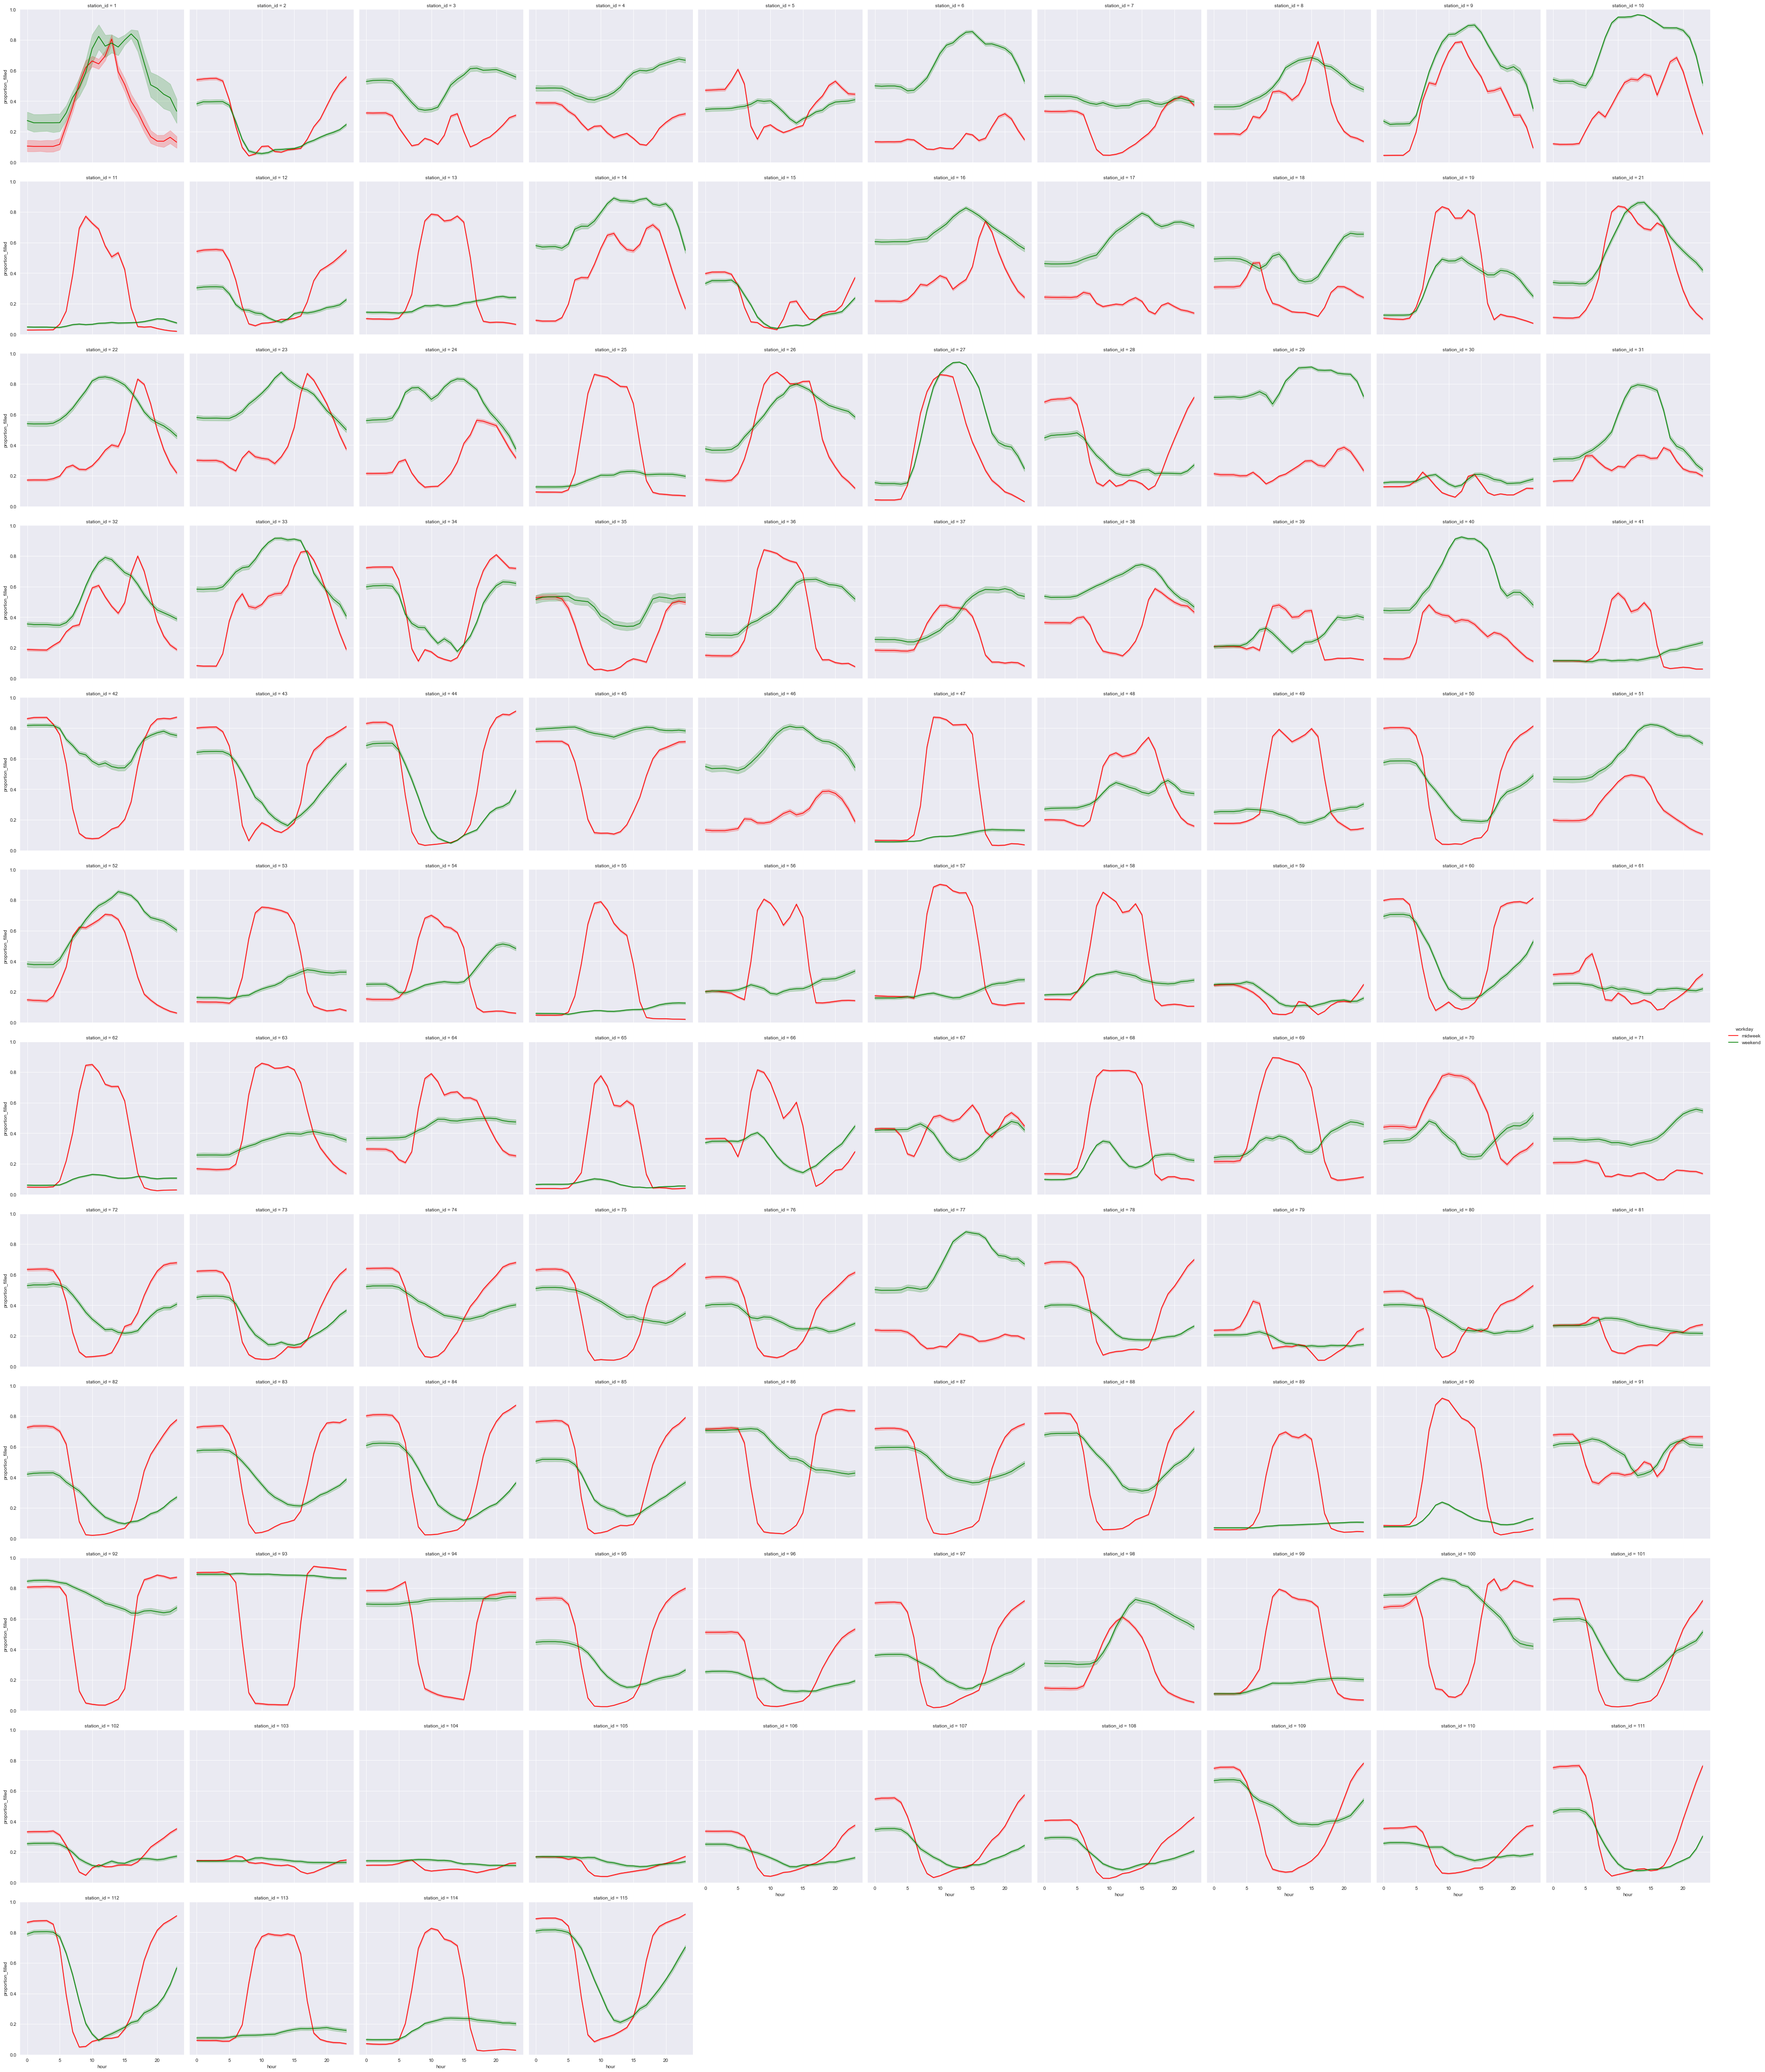

In [69]:
palette = {'weekend': 'green', 'midweek': 'red'}
sns.set_style('darkgrid')
sns.relplot(
x='hour',
y='proportion_filled',
kind = 'line',
data=data_2019_clean,
col='station_id',
col_wrap=10,
hue = 'workday',
palette = palette
        )
plt.ylim(0,1)

Next I've defined functions to do the following:<br>
1. Clean the data further, getting it ready for use in a Kmeans clustering model.
2. Run an Elbow test, this helps identify the optimal number of clusters to use in the model.
3. Run a Kmeans model on the data.
4. Plot the stations on a map of Dublin, colour coding them by cluster.


In [70]:
'''Define function to clean data for use in Kmeans testing'''
def clean_Kmeans_data(data_to_run):
    '''Run Kmeans clustering'''
    #group data into clusters
    data_to_run['cluster_group'] =  data_to_run['workday'].astype(str) + data_to_run['time_of_day'].astype(str) 
    df_personal_use= data_to_run.loc[(data_to_run['activity']=='personal_use')]
    df_kmeans = df_personal_use[['station_id', 'name', 'latitude', 'longitude', 'workday', 'time_of_day', 'proportion_filled','cluster_group']]
    df_kmeans = df_kmeans.groupby(['station_id', 'name', 'latitude', 'longitude', 'cluster_group'],as_index=False)['proportion_filled'].mean()
    df_kmeans = df_kmeans.set_index('station_id')
    #pivot dataframe for clustering
    df_kmeans = df_kmeans.pivot_table(index= ['name', 'station_id','latitude', 'longitude'] , columns=['cluster_group'], values='proportion_filled')
    df_kmeans  = df_kmeans.reset_index()
    df_kmeans  = df_kmeans .set_index('name')
    df_kmeans = df_kmeans.dropna()
    return df_kmeans

In [71]:
'''Define function to run the Elbow test for Kmeans testing'''
def elbow_test(df_kmeans):
    '''Elbow Method - finding the optimal K '''
    distortions = []
    K = range(2,10)
    X = np.array(df_kmeans.drop(columns=['station_id', 'latitude', 'longitude'], axis=1).astype(float))
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

        
    plt.figure(figsize=(10,7))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    return plt.show()

In [72]:
#%%
'''Define function to run Kmeans testing to find similar clusters'''
def find_clusters(df_clusters,n):
    '''Function to run Kmeans clustering'''
    X = np.array(df_clusters.drop(columns=['station_id', 'latitude', 'longitude'], axis = 1).astype(float))
    KM = KMeans(n_clusters=n,random_state=1) 
    KM.fit(X)
    clusters = KM.predict(X)

    locations = df_clusters
    locations['cluster'] = clusters
    locations = locations.sort_values(['station_id'])
    locations = locations.reset_index()

    return locations


In [73]:
'''Define function to plot the clusters on a map of Dublin'''
colourdict_3 ={0: 'blue', 1: 'red', 2: 'orange'}
colourdict_4 = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green'}
colourdict_5 = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 4: 'purple'}
def plot_clusters(plot, title,colourdict_):
    
    colordict = colourdict_
    bstreet = (53.35677,-6.26814)
    dublin_map = folium.Map(location = bstreet,
                            zoom_start=13)
    title_html = f'<h3 align="center" style="font-size:20px"><b>{title}</b></h3>'
    dublin_map.get_root().html.add_child(folium.Element(title_html))
    for LATITUDE, LONGITUDE, cluster, name in zip(plot['latitude'],plot['longitude'], plot['cluster'], plot['name']):
        folium.CircleMarker(
            [LATITUDE, LONGITUDE],
            color = 'b',
            radius = 8,
            fill_color=colordict[cluster],
            fill=True,
            fill_opacity=0.9,
            popup=name
            ).add_to(dublin_map)
     
    # Add the title to the map
    return display(dublin_map)

In [74]:
'''Manipulate data for Kmeans clustering'''
Kmeans_2018 = clean_Kmeans_data(data_2018_clean)
Kmeans_2019 = clean_Kmeans_data(data_2019_clean)
Kmeans_2020 = clean_Kmeans_data(data_2020_clean)
Kmeans_2021 = clean_Kmeans_data(data_2021_clean)
Kmeans_2019.head()

cluster_group,station_id,latitude,longitude,midweekevening,midweekmidday,midweekmorning,midweeknight,weekendevening,weekendmidday,weekendmorning,weekendnight
name,,,,,,,,,,,
AVONDALE ROAD,108,53.359406,-6.276142,0.215203,0.067891,0.118211,0.391680,0.133765,0.099288,0.163980,0.247526
BARROW STREET,70,53.341656,-6.236198,0.335538,0.731245,0.683585,0.379111,0.368601,0.270071,0.430964,0.403438
BENSON STREET,90,53.344154,-6.233451,0.074549,0.722961,0.758609,0.077047,0.099004,0.151905,0.190669,0.092602
BLACKHALL PLACE,88,53.348801,-6.281637,0.383738,0.094978,0.215619,0.791957,0.371776,0.340228,0.555558,0.621610
BLESSINGTON STREET,2,53.356770,-6.268140,0.188888,0.081418,0.106203,0.501810,0.133947,0.080839,0.120802,0.317155


The figures here represent the average occupancy of each station throughout the day.<br>
For example in 2019 the Barrow Street station was, on average, 73% full at midday from Monday - Friday. 

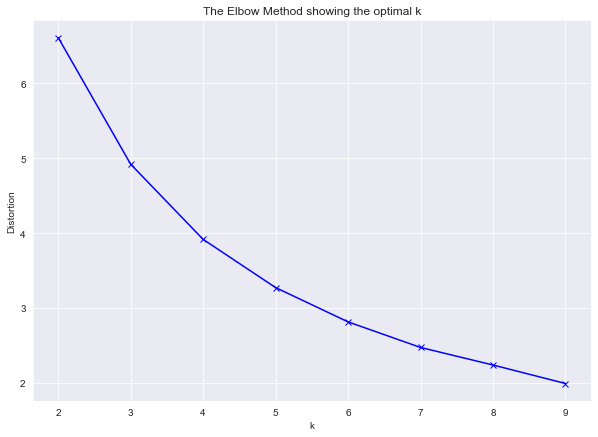

In [75]:
'''Run the elbow test for Kmeans clustering'''
elbow_test_2021 = elbow_test(Kmeans_2021)

## Run Kmeans Clustering
Here I'm running a Kmeans model on the data.<br> 
I've chosen 5 clusters for each year.<br>
The stations that behave similar ie. had simliar shaped graphs above, will be clustered together. 

In [76]:
'''Run Kmeans Clustering'''
clusters_2018 = find_clusters(Kmeans_2018,5)
clusters_2019 = find_clusters(Kmeans_2019,5)
clusters_2020 = find_clusters(Kmeans_2020,5)
clusters_2021 = find_clusters(Kmeans_2021,5)

### Plotting Clusters
When I plot the clusters on a map of Dublin you can see some interesting patterns.<br>
The clusters for 2018 & 2019 are very similar.<br>
They can clearly be split into distinct locations.<br>
* The city centre in the middle
* Offices in the South West
* Transport hubs in East and West
* Residential areas in the North, South and West

We can also see that these clusters change in 2020 & 2021<br>
Most noticebly the office district breaks down. This implies the pattern of usage of these stations has changed.

In [77]:
'''Plot clusters on map for each year'''
plots = [clusters_2018,clusters_2019,clusters_2020,clusters_2021]
titles = ['2018','2019','2020','2021']
colourdicts = [colourdict_5,colourdict_5,colourdict_5,colourdict_5]
for plot,title,colourdict_ in zip(plots,titles,colourdicts):
    plot_clusters(plot,title,colourdict_)

## Merge cluster data
Now that I've grouped the stations into clusters, I'm going to bring this cluster data into the original cleaned data using the function below:

In [78]:
'''Define function to join clusters back into clean data'''
def join_clusters(df_clusters,df_clean):
    '''Join clusters back into clean data'''
    df_clusters[['station_id','cluster']].drop_duplicates()
    df_clusters = df_clusters.sort_values('station_id')
    df_clusters=df_clusters.reset_index()
    df_clusters = df_clusters[['station_id','cluster']]
    df_clean_clusters = df_clean.merge(df_clusters,on='station_id',how='left')
    return df_clean_clusters
'''Join clusters back into clean data'''
data_clean_clusters_2018 = join_clusters(clusters_2018,data_2018_clean)
data_clean_clusters_2019 = join_clusters(clusters_2019,data_2019_clean)
data_clean_clusters_2020 = join_clusters(clusters_2020,data_2020_clean)
data_clean_clusters_2021 = join_clusters(clusters_2021,data_2021_clean)

## Modelling station occupancy
So far I've shown the bike stations can be grouped into clusters that exhibit similar patterns of usage. <br>
I've also shown how these patterns have changed since the Pandemic.<br>
Now using machine learning models I'm going to attempt to predict the occupancy of each station.<br>
My hope is that through modeling, I can visualise how impactful the Pandemic has been on usage behaviour

### Sampling the data for modelling
The dataset I've been using is very large.<br>
For efficiency I'm going to create a function to take a random sample of the data to be used by the models.<br>
I'm also going to group the occupancy into low, medium or high to make modeling it a little easier.

In [79]:
'''define function to take a random sample of data for modelling'''
 # assign capacity low medium or high to proportion filled
    #1 = Low
    #2 = medium
    #3 = high
def capacity(x):
    if x < 20:
        return 1
    elif x > 80:
        return 3
    else:
        return 2
def rf_sample(df,size):
    rf_data = df[['station_id','proportion_filled','pandemic_flag','day_num','hour']].sample(size)
    rf_data['proportion_filled'] = (rf_data['proportion_filled'].round(decimals =1)*100).astype(int) 
    rf_data['capacity'] = rf_data['proportion_filled'].apply(capacity)
    pan_flag = ('pre_pandemic','post_pandemic')
    pan_num = (0,1)
    pan_zip = zip(pan_flag,pan_num)
    pan_list= list(pan_zip)
    pan_dict = dict(pan_list)
    rf_data['pandemic_flag'].replace(pan_dict,inplace=True)
    
    return rf_data

Now I'll use the function to take a random sample of 200,000 rows from each year.<br>
This should leave a large enough dataset to be significant while also being efficient to run. 

In [80]:
'''Take a sample from each year'''
rf_2018 = rf_sample(data_clean_clusters_2018,200000)
rf_2019 = rf_sample(data_clean_clusters_2019,200000)
rf_2020 = rf_sample(data_clean_clusters_2020,200000)
rf_2021 = rf_sample(data_clean_clusters_2021,200000)
rf_combined = pd.concat([rf_2018,rf_2019,rf_2020,rf_2021])
rf_combined.head()

,station_id,proportion_filled,pandemic_flag,day_num,hour,capacity
4491573,54,40,0,2,9,2
4253753,25,10,0,2,20,1
4039716,80,20,0,2,15,2
3037345,8,0,0,0,23,1
906405,78,60,0,3,23,2


I'm now going to use this data to try and predict the capacity of a station ie low medium or high based on the time of day, day of the week and if it's a pre or post pandemic time period.<br>Hopefully I'll see a measure of how impactful the pandemic has been on bike usage.

## Decision Tree Model
To predict the capacity I'm using a decision tree model.<br>

A Decision Trees is a supervised machine learning model<br>
* The leaves of the tree are the low, medium or high capacity.
* The branches of the tree are the combinations of station id, pandemic flag, day and time that lead to each leaf.


First I've split the sampled data into train and test sets.<br>
I've trained the model on 80% of the sample and will predict the capacity of the remaining 20%.<br>



Accuracy:{rf_combined} 0.707045


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

           1       0.67      0.58      0.62     60317
           2       0.73      0.83      0.78    121347
           3       0.58      0.30      0.40     18336

    accuracy                           0.71    200000
   macro avg       0.66      0.57      0.60    200000
weighted avg       0.70      0.71      0.70    200000



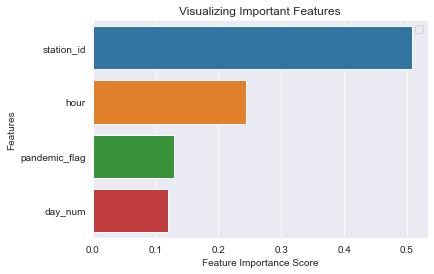

In [81]:
SEED = 1
model = DecisionTreeClassifier(random_state=SEED)
x = rf_combined.drop(['proportion_filled','capacity'],axis=1)
y = rf_combined['capacity']
x_train, x_test, y_train, y_test = train_test_split(x,y)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

print("Accuracy:{rf_combined}",metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test,y_pred))

#print(metrics.confusion_matrix(y_test, Y_pred))
feature_imp = pd.Series(model.feature_importances_,index=['station_id','pandemic_flag','day_num','hour']).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

The model is about 70% accurate.<br>
I've also graphed how important each feature of the model is.<br>
Interestingly, whether we're looking at pre or post pandemic has more impact on the capacity of a station than the day of the week.

## Hyperparameter Tuning
I've used hyperparameter tuning to improve the accuracy of the model below:

In [82]:

'''Hyperparameter tuning'''
from sklearn.model_selection import GridSearchCV
SEED = 1
model = DecisionTreeClassifier(random_state=SEED)
print(model.get_params())
# Define the grid of hyperparameters 'params_dt'
params_dt = {'max_depth': [29,30,35,40],
             'min_samples_leaf': [14,15,20,30],
             'max_features': [0.7,0.8,0.9,0.95]            }
# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=model,                        
                       param_grid=params_dt,                       
                       scoring='accuracy',                                              
                       cv=10,                       
                       n_jobs=-1)
# Fit 'grid_dt' to the training datagrid_
grid_dt.fit(x_train, y_train)
# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_dt.best_params_
# Extract best CV score from 'grid_dt'
best_CV_score = grid_dt.best_score_
# Extract best model from 'grid_dt'
best_model = grid_dt.best_estimator_
# Evaluate test set accuracy
test_acc = best_model.score(x_test,y_test)
# Print test set accuracy

print('Best CV accuracy:\n{}'.format(best_CV_score))
print('Best hyerparameters:\n', best_hyperparams)
print("Test set accuracy of best model:\n{:.3f}".format(test_acc))

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 1, 'splitter': 'best'}
Best CV accuracy:
0.709265
Best hyerparameters:
 {'max_depth': 30, 'max_features': 0.8, 'min_samples_leaf': 20}
Test set accuracy of best model:
0.710


By running the model again on a variety of parameters I can select the optimal parameters for accuracy.<br>
You can see the model has gotten slightly more accurate as a result.